In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import Tool
import numpy as np
import tqdm
import tejapi
from datetime import datetime, timedelta

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [109]:
twse = tejapi.get('TWN/APIPRCD', coid='IX0001',opts={'columns': ['mdate','roi','close_d','vol','low_d','high_d']}, mdate={'gte': '2010-01-01', 'lte':'2025-04-21'}, paginate=True)

In [110]:
twse['roi'] = (twse['roi'] / 100).shift(-2)

In [149]:
# twse['mdate'] = pd.to_datetime(twse['mdate'])
# twse = twse.set_index('mdate')
df = twse

In [ ]:
df = twse
def Cal_RSRS(df, N):
    df=df.copy()
    temp = [np.nan]*N
    
    for row in range(len(df)-N):
        
        y = df['high_d'][row:row+N]
        x = df['low_d'][row:row+N]
        
        beta = np.polyfit(x, y, 1)[0]
        
        temp.append(beta)
        
    df['RSRS'] = temp
    return df

RSRS_df=Cal_RSRS(df,18)

In [ ]:
def Cal_RSRS_Zscore(datas,N, M):
    df=Cal_RSRS(datas,N)
    df['RSRS_temp'] = df['RSRS'].fillna(0)
    # df = Cal_RSRS(df, N)  
    ZSCORE = (df['RSRS_temp']-df['RSRS_temp'].rolling(M).mean()
              )/df['RSRS_temp'].rolling(M).std()
    df['RSRS_Z'] = ZSCORE
    df = df.drop(columns='RSRS_temp')
    return df
RSRS_Z = Cal_RSRS_Zscore(RSRS_df, 18,600)

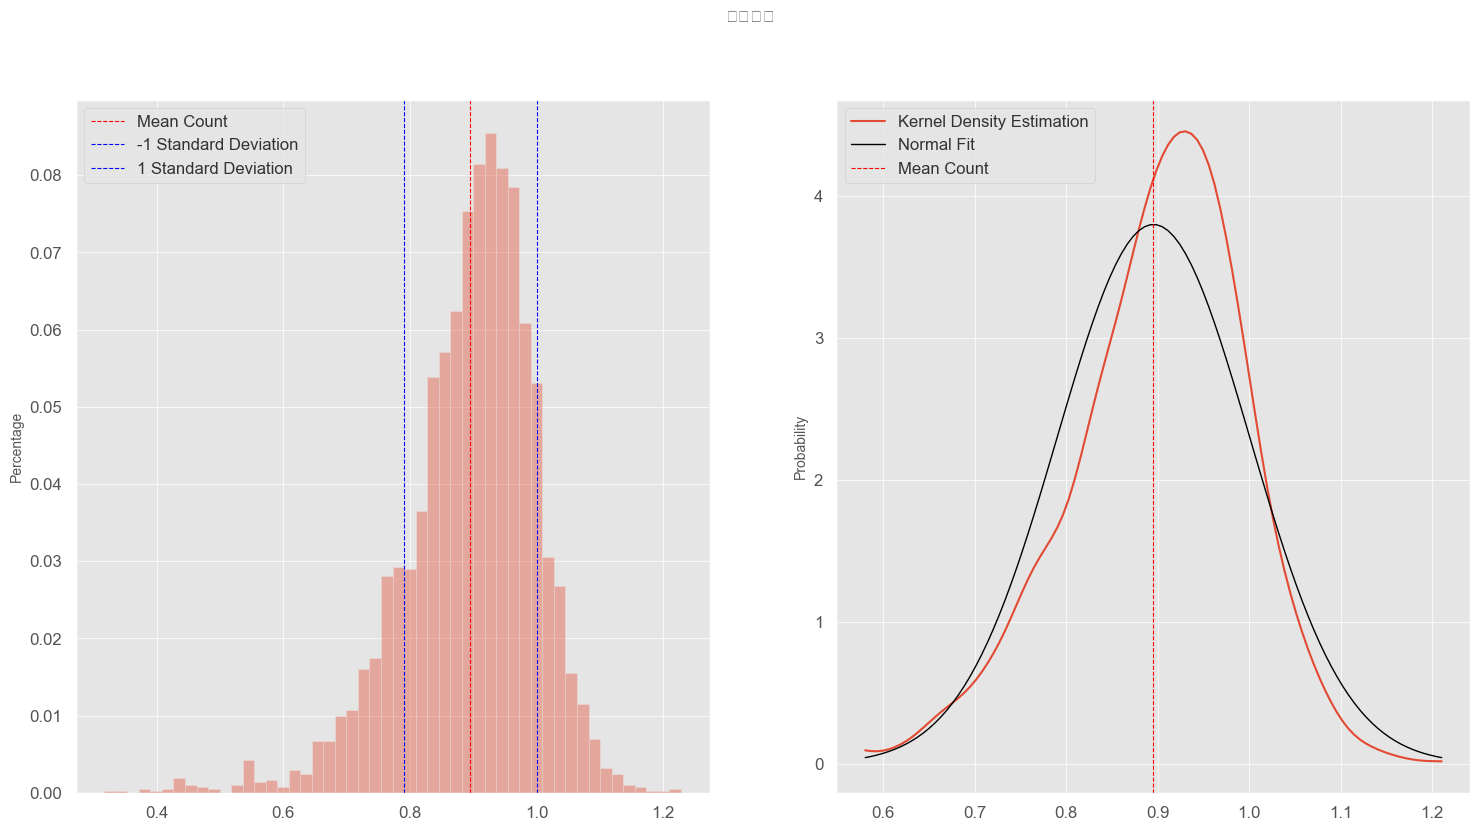

In [ ]:
import scipy.stats as st
def stat_depict_plot(df, col,title):
    
    df = df[~df[col].isna()].copy()
    
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(18, 9))
    plt.suptitle(title)
    v = df[col]
    x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(v)

    # plot the histogram
    plt.subplot(121)
    plt.hist(v, 50, weights=np.ones(len(v))/len(v), alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()


stat_depict_plot(RSRS_df,'RSRS','數據分布')

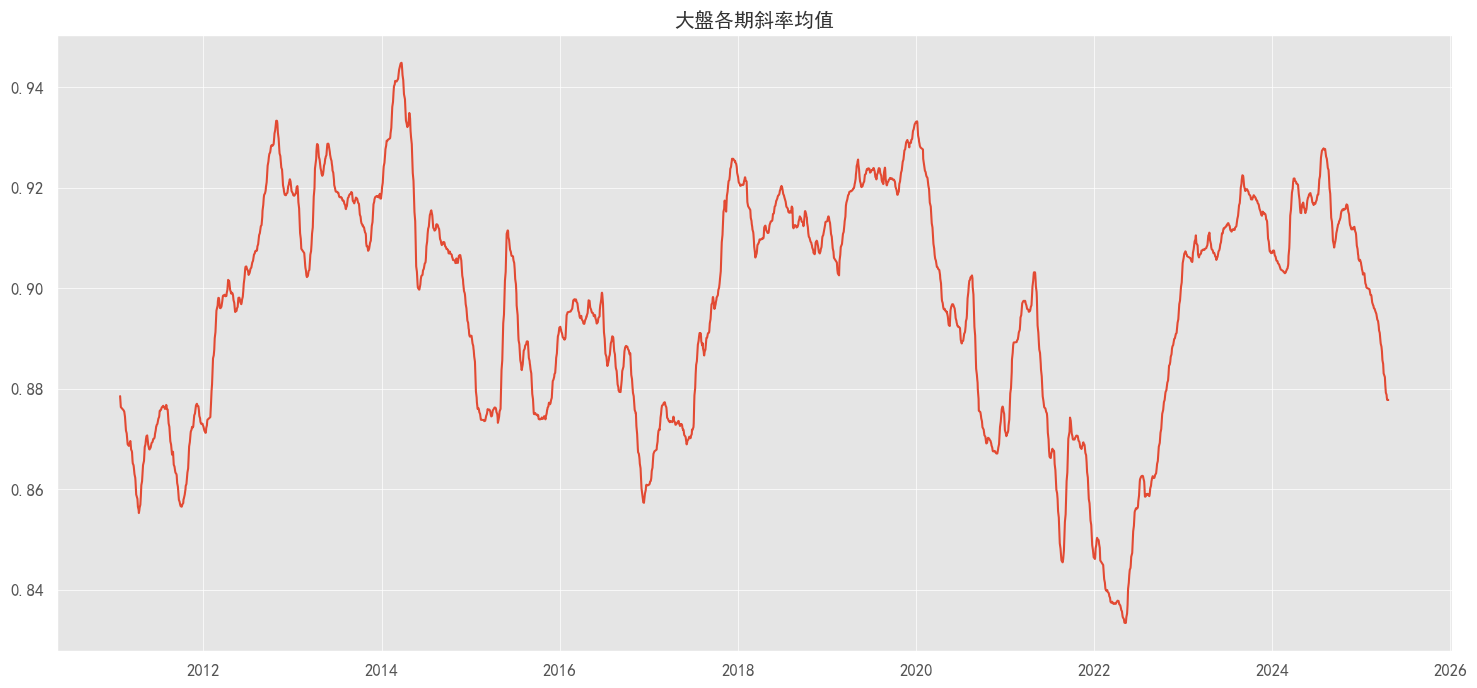

In [193]:
plt.figure(figsize=(18,8))
plt.title('大盤各期斜率均值')
plt.plot(RSRS_df['RSRS'].rolling(250).mean())

In [195]:
def summary(df, signal_name=['basic_signal', 'z_signal']):
    summary_dic = {}
    index_labels = [
        '年化報酬率', '累積報酬率', '夏普比率', '最大回撤',
        '持倉總天數', '交易次數', '平均持倉天數',
        '獲利天數', '虧損天數', '勝率（日）',
        '平均獲利率（日）', '平均虧損率（日）', '日盈虧比',
        '獲利次數', '虧損次數', '單次最大獲利', '單次最大虧損',
        '勝率（次）', '平均獲利率（次）', '平均虧損率（次）', '次盈虧比'
    ]

    zh_label_map = {
        'basic_signal': '斜率指標策略',
        'z_signal': '標準分數策略',
        'RSRS_Revise_signal': '修正標準分策略',
        'RSRS_Positive_signal': '右偏標準分策略',
    }
    col_names = [zh_label_map.get(s, s) for s in signal_name]

    def format_pct(x): return '{:.2%}'.format(x)

    for sig in signal_name:
        ret = df['ret'] * df[sig]
        cum = (1 + ret).cumprod()

        annual_ret = cum.iloc[-1]**(250 / len(ret)) - 1
        total_ret = cum.iloc[-1] - 1
        max_drawdown = -np.min(cum / np.maximum.accumulate(np.nan_to_num(cum)) - 1)
        sharpe = np.mean(ret) / np.nanstd(ret, ddof=1) * np.sqrt(250)

        holding = df[sig]
        holding_shift = np.nan_to_num(df[sig].shift(-1))
        trade_mask = (holding == 1) & (holding_shift < holding)
        trade_count = trade_mask.sum()
        total_hold = holding.sum()
        avg_hold_days = total_hold / trade_count

        win_days = np.sum(ret > 0)
        loss_days = np.sum(ret < 0)
        win_ratio_day = win_days / total_hold
        avg_win_day = ret[ret > 0].mean()
        avg_loss_day = ret[ret < 0].mean()
        win_loss_day_ratio = win_days / loss_days

        temp_df = df.copy()
        temp_df['group'] = (df[sig] != df[sig].shift(1)).cumsum()
        trade_df = temp_df[temp_df[sig] == 1].groupby('group')['ret'].sum()

        win_trades = np.sum(trade_df > 0)
        loss_trades = np.sum(trade_df < 0)
        max_win = trade_df.max()
        max_loss = trade_df.min()
        win_ratio_trade = win_trades / len(trade_df)
        avg_win_trade = trade_df[trade_df > 0].mean()
        avg_loss_trade = trade_df[trade_df < 0].mean()
        win_loss_trade_ratio = win_trades / loss_trades

        summary_dic[sig] = [
            format_pct(annual_ret),
            format_pct(total_ret),
            sharpe,
            format_pct(max_drawdown),
            total_hold,
            trade_count,
            avg_hold_days,
            win_days,
            loss_days,
            format_pct(win_ratio_day),
            format_pct(avg_win_day),
            format_pct(avg_loss_day),
            win_loss_day_ratio,
            win_trades,
            loss_trades,
            format_pct(max_win),
            format_pct(max_loss),
            format_pct(win_ratio_trade),
            format_pct(avg_win_trade),
            format_pct(avg_loss_trade),
            win_loss_trade_ratio
        ]

    result = pd.DataFrame(summary_dic, index=index_labels)
    result.columns = col_names
    return result


In [ ]:
def RSRS_Strategy(datas, N, M):
    df = datas.copy()
    RSRS_Z = Cal_RSRS_Zscore(df, N, M)  # 計算 RSRS 標準分數指標

    # 扣掉前期缺資料的期間
    RSRS_Z = RSRS_Z[max(N, M):]

    print('回測起始日：', min(RSRS_Z.index))

    basic_signal = []
    for i in range(len(RSRS_Z)):
        if RSRS_Z['RSRS'][i] > 1.02:
            basic_signal.append(1)
        else:
            if i != 0:
                if basic_signal[-1] and RSRS_Z['RSRS'][i] > 0.78:
                    basic_signal.append(1)
                else:
                    basic_signal.append(0)
            else:
                basic_signal.append(0)

    RSRS_Z['basic_signal'] = basic_signal

    z_signal = []
    S = 0.7  # 常見研報預設參數
    for i in range(len(RSRS_Z)):
        if RSRS_Z['RSRS_Z'][i] > S:
            z_signal.append(1)
        else:
            if i != 0:
                if z_signal[-1] and RSRS_Z['RSRS_Z'][i] > -S:
                    z_signal.append(1)
                else:
                    z_signal.append(0)
            else:
                z_signal.append(0)

    RSRS_Z['z_signal'] = z_signal

    RSRS_Z['ret'] = RSRS_Z['close_d'].pct_change()

    # 策略淨值
    BASIC_CUM = (1 + RSRS_Z['basic_signal'] * RSRS_Z['ret']).cumprod()
    Z_CUM = (1 + RSRS_Z['z_signal'] * RSRS_Z['ret']).cumprod()
    benchmark = (1 + RSRS_Z['ret']).cumprod()

    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(BASIC_CUM, label='斜率指標策略')
    ax1.plot(Z_CUM, label='標準分數策略')
    ax1.plot(benchmark, label='大盤基準')
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title('RSRS 策略 vs 大盤報酬淨值曲線')
    plt.xlabel('日期')
    plt.ylabel('累積報酬（淨值）')
    plt.legend(loc='best')
    plt.show()
    display(summary(RSRS_Z))


回測起始日： 2012-06-05 00:00:00


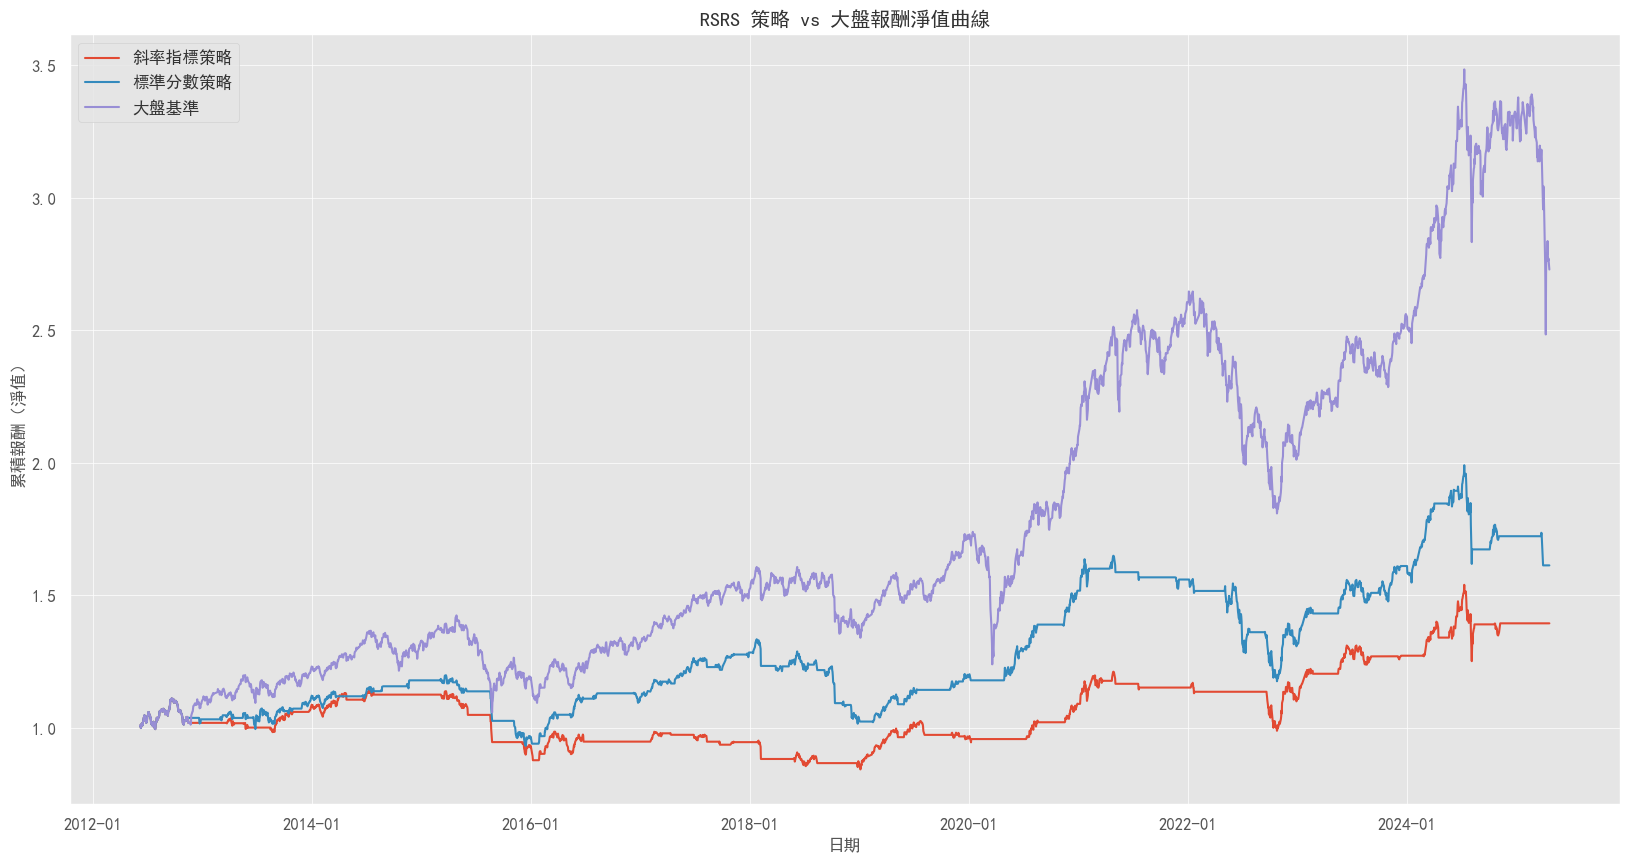

,斜率指標策略,標準分數策略
年化報酬率,2.68%,3.87%
累積報酬率,39.48%,61.34%
夏普比率,0.332902,0.415614
最大回撤,26.07%,28.69%
持倉總天數,1203,1573
交易次數,35,54
平均持倉天數,34.371429,29.12963
獲利天數,644,865
虧損天數,559,708
勝率（日）,53.53%,54.99%


In [213]:
RSRS_Strategy(df,18,600)

# R方

In [215]:
def Cal_RSRS_Revise(datas, N, M):
    df = datas.copy()
    df = Cal_RSRS_Zscore(df, N, M)
    # R方
    temp = [np.nan]*N
    for row in range(len(df)-N):
        x = sm.add_constant(df['low_d'][row:row+N])
        y = df['high_d'][row:row+N]
        r = sm.OLS(y, x).fit().rsquared
        temp.append(r)

    df['rsquared'] = temp
    df['RSRS_Revise'] = df['rsquared']*df['RSRS_Z']
    return df

RSRS_Revise = Cal_RSRS_Revise(df, 18, 600)

回測起始日： 2012-06-05 00:00:00


<Figure size 1000x600 with 0 Axes>

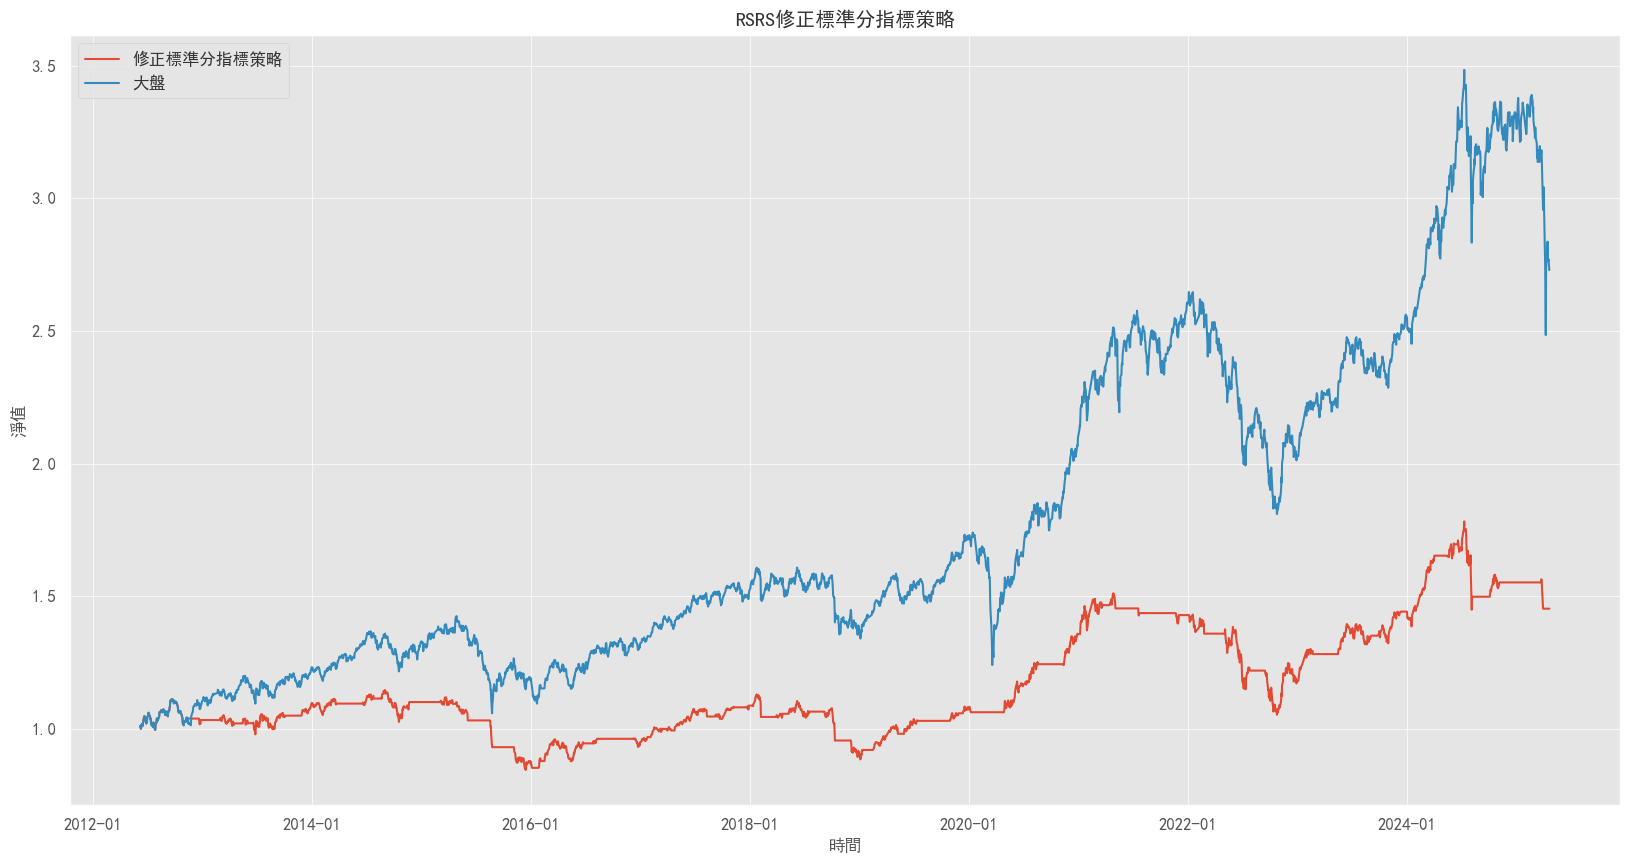

In [222]:
import matplotlib.dates as mdates
def RSRS_Strategy_Revise(datas, N, M,pl=True):
    df=datas.copy()
    RSRS_Z = Cal_RSRS_Revise(df,N, M) 
    
    # 需要扣除前期計算的600日
    RSRS_Z=RSRS_Z[max(N,M):]
    
    print('回測起始日：',min(RSRS_Z.index))

    z_singal = []
    S = 0.7
    for row in range(len(RSRS_Z)):

        if RSRS_Z['RSRS_Revise'][row] > S:
            z_singal.append(1)

        else:
            if row != 0:
                if z_singal[-1] and RSRS_Z['RSRS_Revise'][row] > -S:
                    z_singal.append(1)
                else:
                    z_singal.append(0)
            else:
                z_singal.append(0)

    RSRS_Z['z_singal'] = z_singal
    
    # RSRS_Z=cal_fee(RSRS_Z,'z_singal')
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close_d'].pct_change()
 
    Z_CUM = (1+RSRS_Z['z_singal']*RSRS_Z['ret']).cumprod()
    # Z_CUM_fee = (1+RSRS_Z['z_singal']*RSRS_Z['ret']-RSRS_Z['cost']).cumprod()
    benchmark = (1+RSRS_Z['ret']).cumprod()
    if pl:
        plt.figure()
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.plot(Z_CUM, label='修正標準分指標策略')
        ax1.plot(benchmark, label='大盤')

        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.legend(loc='best')
        plt.xlabel('時間')
        plt.ylabel('淨值')
        plt.title('RSRS修正標準分指標策略')
        plt.show()
    else:
        return RSRS_Z
RSRS_Strategy_Revise(df,18,600)

# compare

回測起始日： 2012-06-05 00:00:00


<Figure size 1000x600 with 0 Axes>

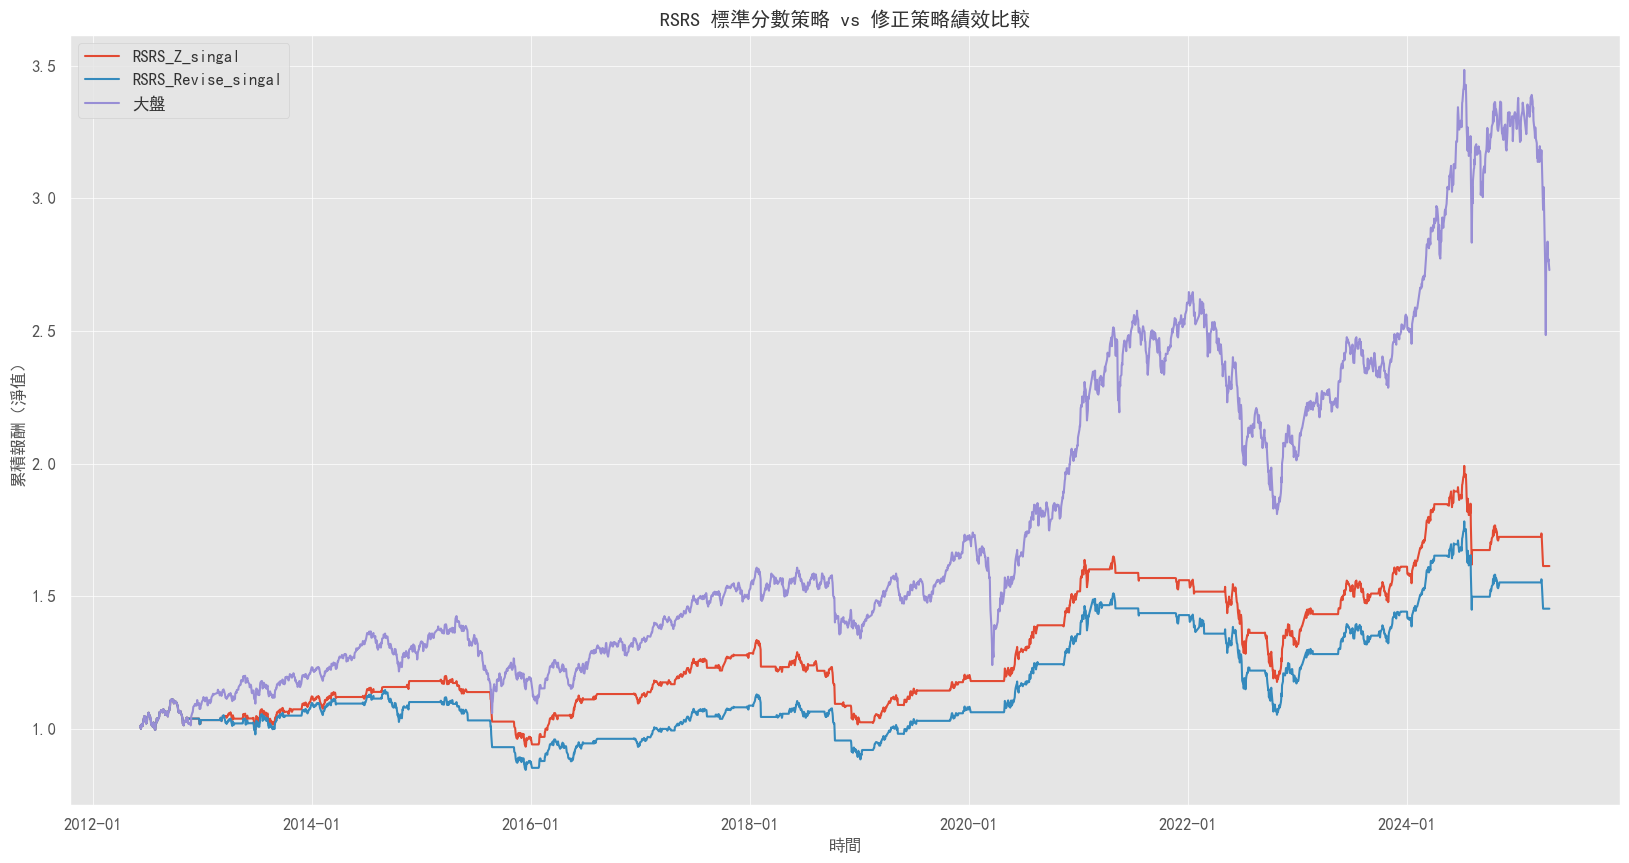

,RSRS_Z_singal,RSRS_Revise_singal
年化報酬率,3.87%,3.01%
累積報酬率,61.34%,45.26%
夏普比率,0.415614,0.326811
最大回撤,28.69%,30.31%
持倉總天數,1573,1676
交易次數,54,48
平均持倉天數,29.12963,34.916667
獲利天數,865,907
虧損天數,708,769
勝率（日）,54.99%,54.12%


In [224]:
def Compare_RSRS_Strategy(datas, N, M):
    df = datas.copy()

    RSRS_Z = Cal_RSRS_Revise(df, N, M)  # 計算修正後的 RSRS 標準分數指標

    signal_name = ['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise'.split(',')]
    RSRS_Z = RSRS_Z[max(N, M):]  # 移除前期不足樣本的期間

    print('回測起始日：', min(RSRS_Z.index))
    
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Z', upper=0.7, lower=-0.7)
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Revise', upper=0.7, lower=-0.7)

    RSRS_Z['ret'] = RSRS_Z['close_d'].pct_change()

    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    for name in signal_name:
        NAV = (1 + RSRS_Z[name] * RSRS_Z['ret']).cumprod()
        ax1.plot(NAV, label=name)

    benchmark = (1 + RSRS_Z['ret']).cumprod()
    ax1.plot(benchmark, label='大盤')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('時間')
    plt.ylabel('累積報酬（淨值）')
    plt.title('RSRS 標準分數策略 vs 修正策略績效比較')
    plt.show()

    display(summary(RSRS_Z, signal_name))
def get_singal(datas, singal_name, upper, lower):
    signals = []

    for i in range(len(datas)):
        if datas[singal_name][i] > upper:
            signals.append(1)
        else:
            if i != 0:
                if signals[-1] and datas[singal_name][i] > lower:
                    signals.append(1)
                else:
                    signals.append(0)
            else:
                signals.append(0)

    datas[singal_name + '_singal'] = signals
    return datas
Compare_RSRS_Strategy(df, 18, 600)

# 右偏

In [225]:
def Cal_RSRS_Positive(datas,N,M):
    df=Cal_RSRS_Revise(datas,N,M)
    df['RSRS_Positive']=df['RSRS_Revise']*df['RSRS']
    return df

RSRS_Positive=Cal_RSRS_Positive(df,18,600)

回測起始日： 2011-03-21 00:00:00


<Figure size 1000x600 with 0 Axes>

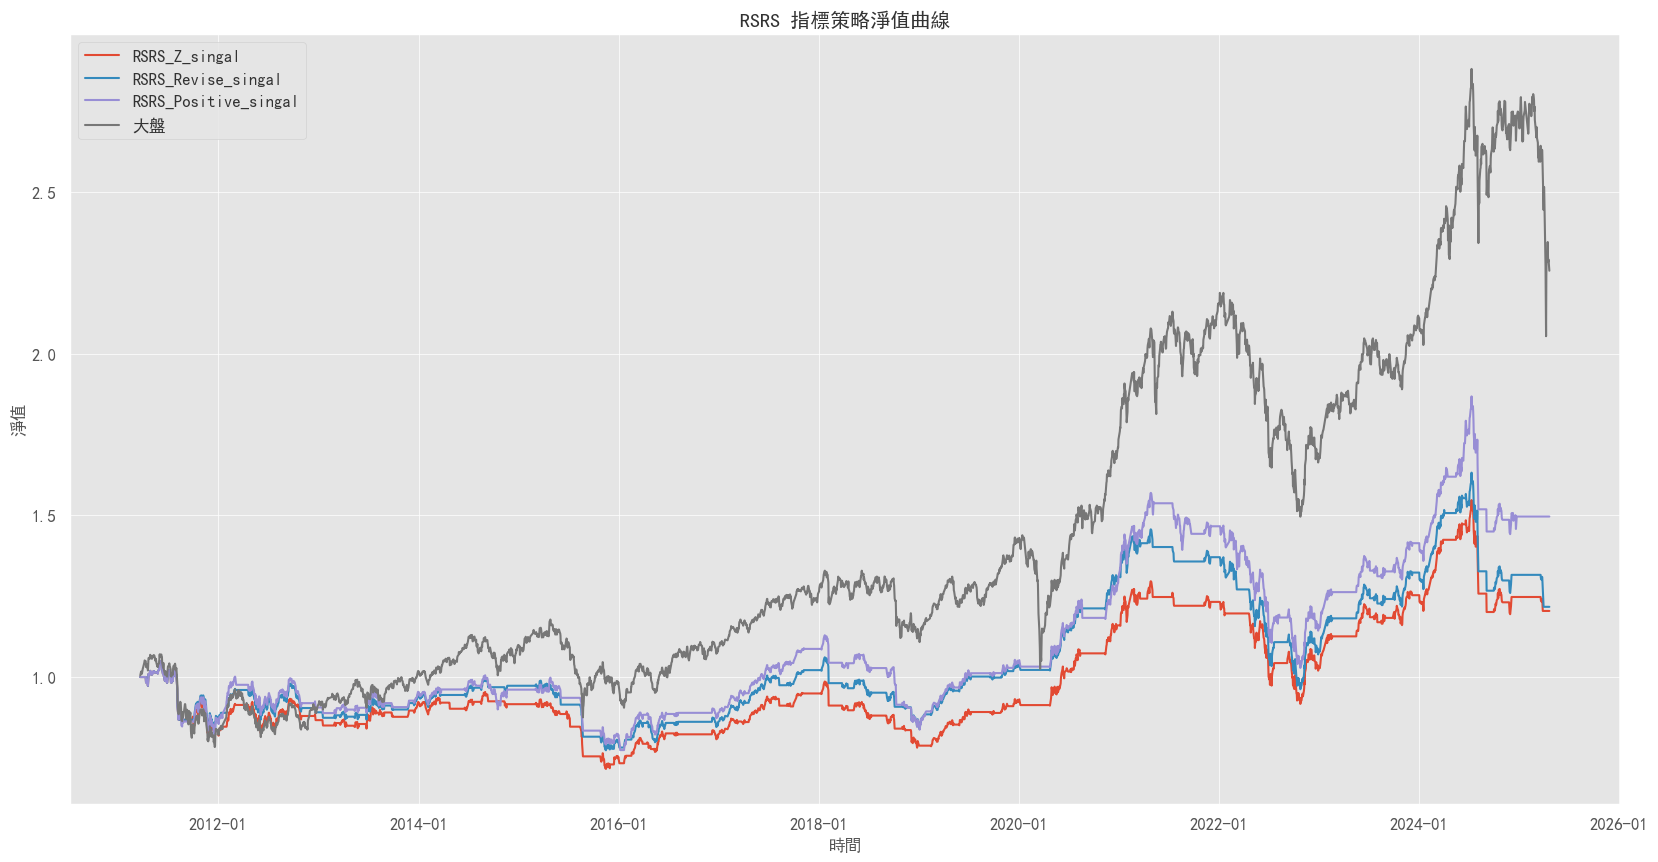

,RSRS_Z_singal,RSRS_Revise_singal,RSRS_Positive_singal
年化報酬率,1.36%,1.43%,2.96%
累積報酬率,20.43%,21.70%,49.63%
夏普比率,0.177225,0.182216,0.2991
最大回撤,31.80%,33.95%,34.48%
持倉總天數,1757,1819,2083
交易次數,72,66,53
平均持倉天數,24.402778,27.560606,39.301887
獲利天數,938,970,1100
虧損天數,819,849,983
勝率（日）,53.39%,53.33%,52.81%


In [229]:
def RSRS_Positive_Strategy(datas, N, M):
    df = datas.copy()

    RSRS_Z = Cal_RSRS_Positive(df, N, M)
    singal_name = ['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    RSRS_Z = RSRS_Z[max(N, M) - 1:]

    print('回測起始日：', min(RSRS_Z.index))

    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Z', 0.7, -0.7)
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Revise', 0.7, -0.7)
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Positive', 0.7, -0.7)

    RSRS_Z['ret'] = RSRS_Z['close_d'].pct_change()

    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    for n in singal_name:
        CUM = (1 + RSRS_Z[n] * RSRS_Z['ret']).cumprod()
        ax1.plot(CUM, label=n)

    benchmark = (1 + RSRS_Z['ret']).cumprod()
    ax1.plot(benchmark, label='大盤')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('時間')
    plt.ylabel('淨值')
    plt.title('RSRS 指標策略淨值曲線')
    plt.show()

    display(summary(RSRS_Z, singal_name))
RSRS_Positive_Strategy(df, 16, 300)

# 市場濾網

In [ ]:
def RSRS_MA_Strategy(datas, N, M):
    df = datas.copy()
    RSRS_Z = Cal_RSRS_Positive(df, N, M)
    
    singal_name = ['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    
    RSRS_Z['MA'] = RSRS_Z['close'].rolling(20).mean()
    RSRS_Z = RSRS_Z[max(N, M) - 1:]

    print('回測起始日：', min(RSRS_Z.index))

    RSRS_Z = Add_MA(RSRS_Z, 'RSRS_Z')
    RSRS_Z = Add_MA(RSRS_Z, 'RSRS_Revise')
    RSRS_Z = Add_MA(RSRS_Z, 'RSRS_Positive')

    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()

    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    for n in singal_name:
        CUM = (1 + RSRS_Z[n] * RSRS_Z['ret']).cumprod()
        ax1.plot(CUM, label=n)

    benchmark = (1 + RSRS_Z['ret']).cumprod()
    ax1.plot(benchmark, label='大盤')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('時間')
    plt.ylabel('淨值')
    plt.title('RSRS 指標策略淨值曲線')
    plt.show()

    display(summary(RSRS_Z, singal_name))
def Add_MA(datas, singal_name):
    df = datas.copy()
    df['shift_3'] = df['MA'].shift(3)
    df['shift_1'] = df['MA'].shift(1)
    df = get_singal(df, singal_name, 0.7, -0.7)
    df[singal_name + '_singal'] = (df['shift_1'] > df['shift_3']) & (df[singal_name + '_singal'] == 1)
    datas[singal_name + '_singal'] = df[singal_name + '_singal']
    return datas
RSRS_MA_Strategy(df, 16, 300)